In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
import .VirusLoadCurve

In [4]:
io = IOBuffer(append=true)
print(io, @sprintf "\nData & \$\\mx\$ & \$\\mn\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
    print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.minimizer[6], 1) floor(result.fit.minimizer[6]))
    print(io, @sprintf "\$10^{-7}\$ & ")
    print(io, @sprintf "%.2f & " result.fit.minimizer[1])
    print(io, @sprintf "%.2f & " result.fit.minimizer[2])
    print(io, @sprintf "%.2f & " result.fit.minimizer[5])
    print(io, @sprintf "%.2f & " result.fit.minimizer[3])
    print(io, @sprintf "%.2f \\\\ \n" result.fit.minimizer[4])
end

VLFResultsLatex (generic function with 1 method)

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [5]:
tdata = [4.0/24.0, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.]
RAWDATA = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(RAWDATA, Symbol.(tdata))

,0.16666666666666666,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0


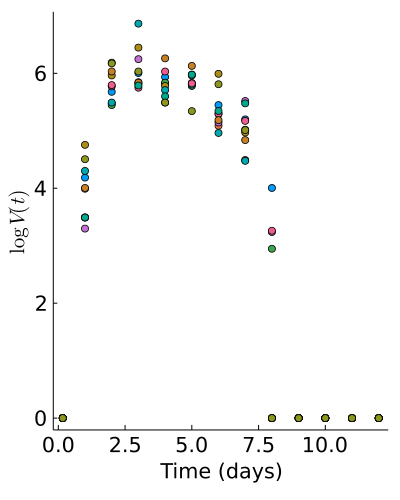

In [6]:
plt = plot(legend=:none, grid=:none, 
    xaxis=("Time (days)", font(14)), yaxis=(L"\log\,V(t)", font(14)), size = (400, 500))
[plot!(tdata, RAWDATA[i, :], seriestype=:scatter) for i in 1:size(RAWDATA, 1)]
savefig(figdir*"Smith2018Data.pdf")
display(plt)

### Average of data

In [7]:
vdata_avg = mean(RAWDATA, dims=1)[:]
vdata_std = std(RAWDATA, dims=1)[:];

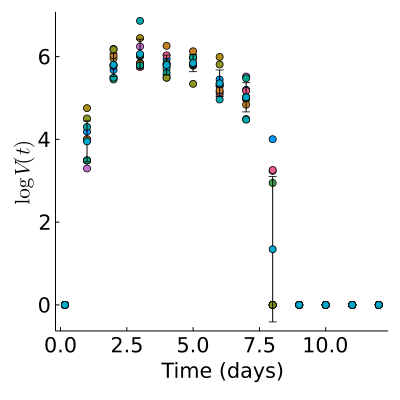

In [8]:
plot!(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off, size = (400, 400),
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data

In [9]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(RAWDATA, 1, :)[:];

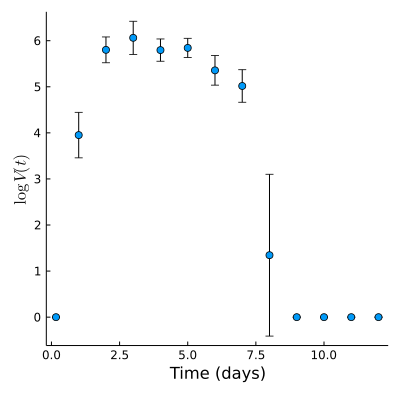

In [10]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off,  size = (400, 400),
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

We'll use the combined data. But the average data shows similar results.

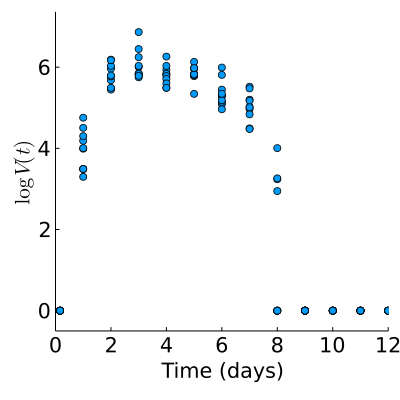

In [11]:
data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
plot(data)

## Fitting models to data

### Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [12]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
resultVLF = VirusLoadCurve.fitVLF(data, par0)
summary(resultVLF)

SAMIN results
NO CONVERGENCE: MAXEVALS exceeded

     Obj. value:          39.83677

       parameter      search width
         0.95417           1.79000 
         2.20350           2.65000 
         6.08981           2.36000 
         7.61057           5.20000 
         0.20000         195.09221 
         6.06164           6.00000 
RSS = 3.98368e+01
  a₁ = 9.542e-01 (initial=7.000e-01)
  a₂ = 2.204e+00 (initial=2.880e+00)
  b₁ = 6.090e+00 (initial=6.000e+00)
  b₂ = 7.611e+00 (initial=7.600e+00)
  α = 2.000e-01 (initial=2.000e-01)
  logVmax = 6.062e+00 (initial=5.000e+00)


In [13]:
VLFResultsLatex("Mice data", resultVLF)
print(read(io, String))


Data & $\mx$ & $\mn$ & $a_1$ & $a_2$ & $\alpha$ & $b_1$ & $b_2$ \\ 
Mice data & 1.15 $\cdot 10^{6}$ & $10^{-7}$ & 0.95 & 2.20 & 0.20 & 6.09 & 7.61 \\ 


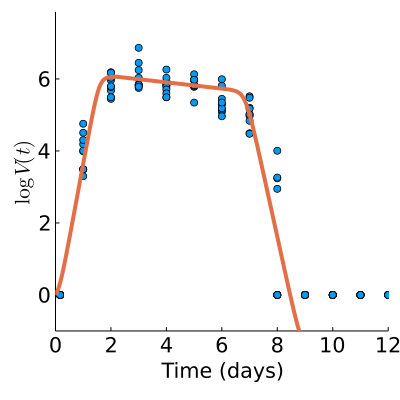

In [14]:
pt = plot(data)
plot!(pt, resultVLF)
savefig(figdir*"Smith2018VLFDataFit.pdf")
savefig(figdir*"Smith2018VLFDataFit.png")
display(pt)

### Standard virus-target ODE Model


The standard viral kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*

In [15]:
#       β     , k     , δ     , K     , p     , c
# par0 = [2.5e-4, 1.5e+0, 1.6e+6, 5.0e+4, 2.1e+0, 1.5e+1]
par0 = [9.9e-5, 1.6e+6, 1.0e+5, 1.7e+0, 1.2e+1]
lb   = [1e-6  , 1e+4  , 1e+2  , 1e-1  , 1e+0  ]
ub   = [1e-1  , 4e+6  , 1e+6  , 1e+3  , 1e+3  ]
resultVTM = VirusLoadCurve.fitVTM(data, par0, lb=lb, ub=ub)
summary(resultVTM)

RSS = 3.57378e+01 (convergence: true)
  β = 2.779e-04 (CI=(9.271e-05, 4.631e-04), initial=9.900e-05)
  δ = 1.532e+06 (CI=(1.368e+06, 1.696e+06), initial=1.600e+06)
  K = 3.128e+04 (CI=(-1.904e+03, 6.445e+04), initial=1.000e+05)
  p = 1.666e+00 (CI=(3.146e-02, 3.300e+00), initial=1.700e+00)
  c = 1.358e+01 (CI=(-2.264e+00, 2.942e+01), initial=1.200e+01)


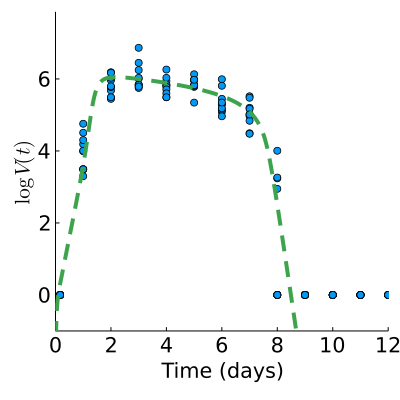

In [16]:
pt = plot(data)
plot!(pt, resultVTM, color=3)
savefig(figdir*"Smith2018ODEDataFit.pdf")
savefig(figdir*"Smith2018ODEDataFit.png")
display(pt)

### Comparing both models

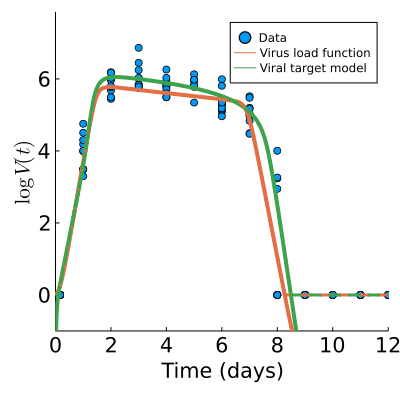

In [18]:
pt = plot(data, legend=true)
plot!(pt, resultVLF, color=2)
plot!(pt, resultVTM, linestyle=:solid, color=3)
plot!(pt, resultVLF, empirical=true, linestyle=:dash, linewidth=3, color=2, label=nothing)
plot!(pt, resultVTM, empirical=true, linestyle=:dash, linewidth=3, color=3, label=false)
savefig(figdir*"Smith2018DataFit.pdf")
savefig(figdir*"Smith2018DataFit.png")
display(pt)

In [19]:
summary(resultVLF)
summary(resultVTM)

RSS = 3.99685e+01
  a₁ = 8.787e-01 (initial=7.000e-01)
  a₂ = 2.049e+00 (initial=2.880e+00)
  b₁ = 6.244e+00 (initial=6.000e+00)
  b₂ = 7.588e+00 (initial=7.600e+00)
  α = 2.000e-01 (initial=2.000e-01)
  logVmax = 5.778e+00 (initial=5.000e+00)
RSS = 3.57378e+01 (convergence: true)
  β = 2.779e-04 (CI=(9.271e-05, 4.631e-04), initial=9.900e-05)
  δ = 1.532e+06 (CI=(1.368e+06, 1.696e+06), initial=1.600e+06)
  K = 3.128e+04 (CI=(-1.904e+03, 6.445e+04), initial=1.000e+05)
  p = 1.666e+00 (CI=(3.146e-02, 3.300e+00), initial=1.700e+00)
  c = 1.358e+01 (CI=(-2.264e+00, 2.942e+01), initial=1.200e+01)
